# Potato Disease Classification

In [2]:
#!pip install IPython

#                                CONVOLUTIONAL NEURAL NETWORK

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


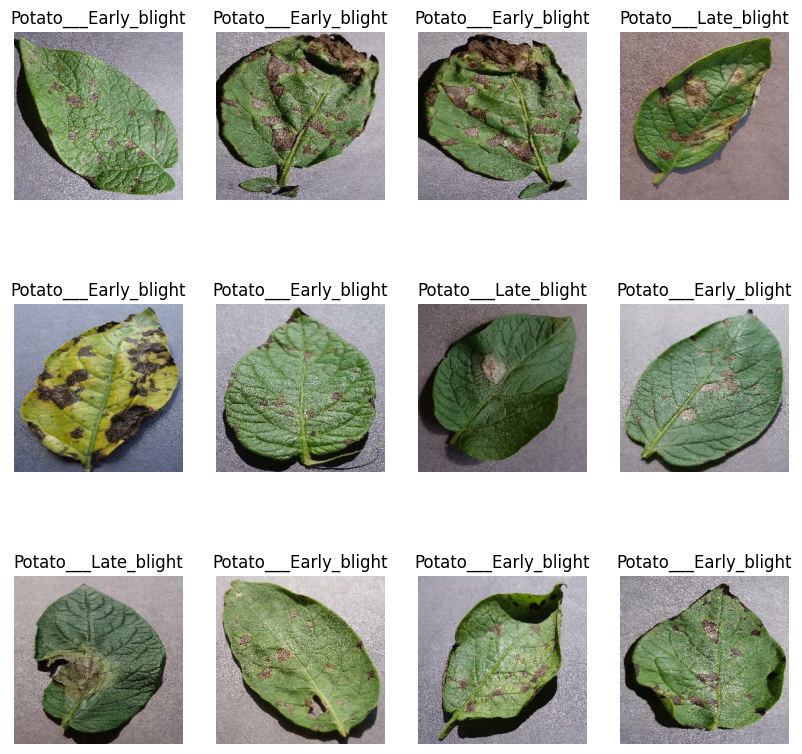

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 115s 2s/step - loss: 0.9166 - accuracy: 0.4815 - val_loss: 0.8689 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 103s 2s/step - loss: 0.7734 - accuracy: 0.6140 - val_loss: 0.8915 - val_accuracy: 0.6094
Epoch 3/50
54/54 [==============================] - 105s 2s/step - loss: 0.5826 - accuracy: 0.7569 - val_loss: 0.6543 - val_accuracy: 0.6875
Epoch 4/50
54/54 [==============================] - 103s 2s/step - loss: 0.4204 - accuracy: 0.8189 - val_loss: 0.5826 - val_accuracy: 0.7135
Epoch 5/50
54/54 [==============================] - 102s 2s/step - loss: 0.3398 - accuracy: 0.8513 - val_loss: 0.3398 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 103s 2s/step - loss: 0.2286 - accuracy: 0.9062 - val_loss: 0.6205 - val_accuracy: 0.8229
Epoch 7/50
54/54 [==============================] - 77s 1s/step - loss: 0.2317 - accuracy: 0.9051 - val_loss: 0.2525 - val_accuracy: 0.8906
Epoch 8/50
54/

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 295ms/step - loss: 0.0900 - accuracy: 0.9727


In [34]:
scores

[0.09004419296979904, 0.97265625]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

50

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.91664719581604,
 0.7733584642410278,
 0.5826141238212585,
 0.42036059498786926,
 0.33984047174453735]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

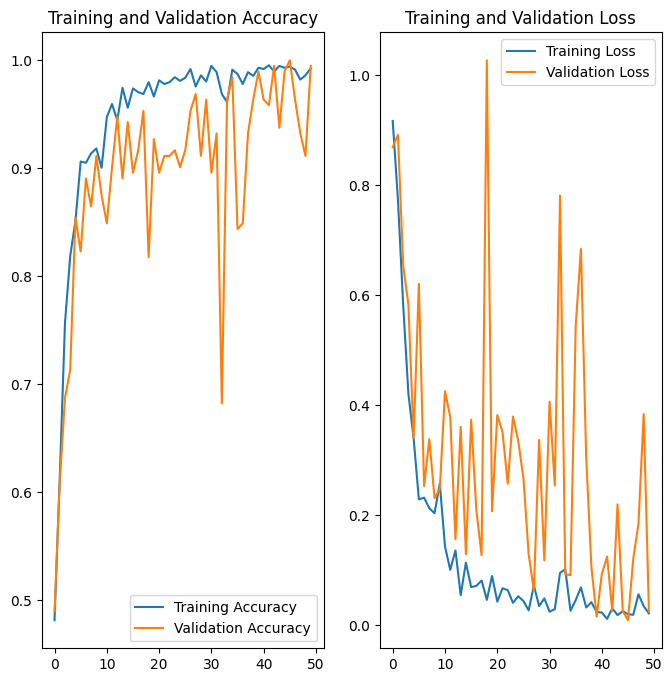

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 492ms/step
predicted label: Potato___healthy


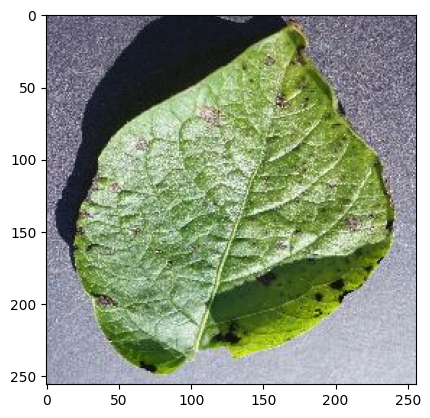

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


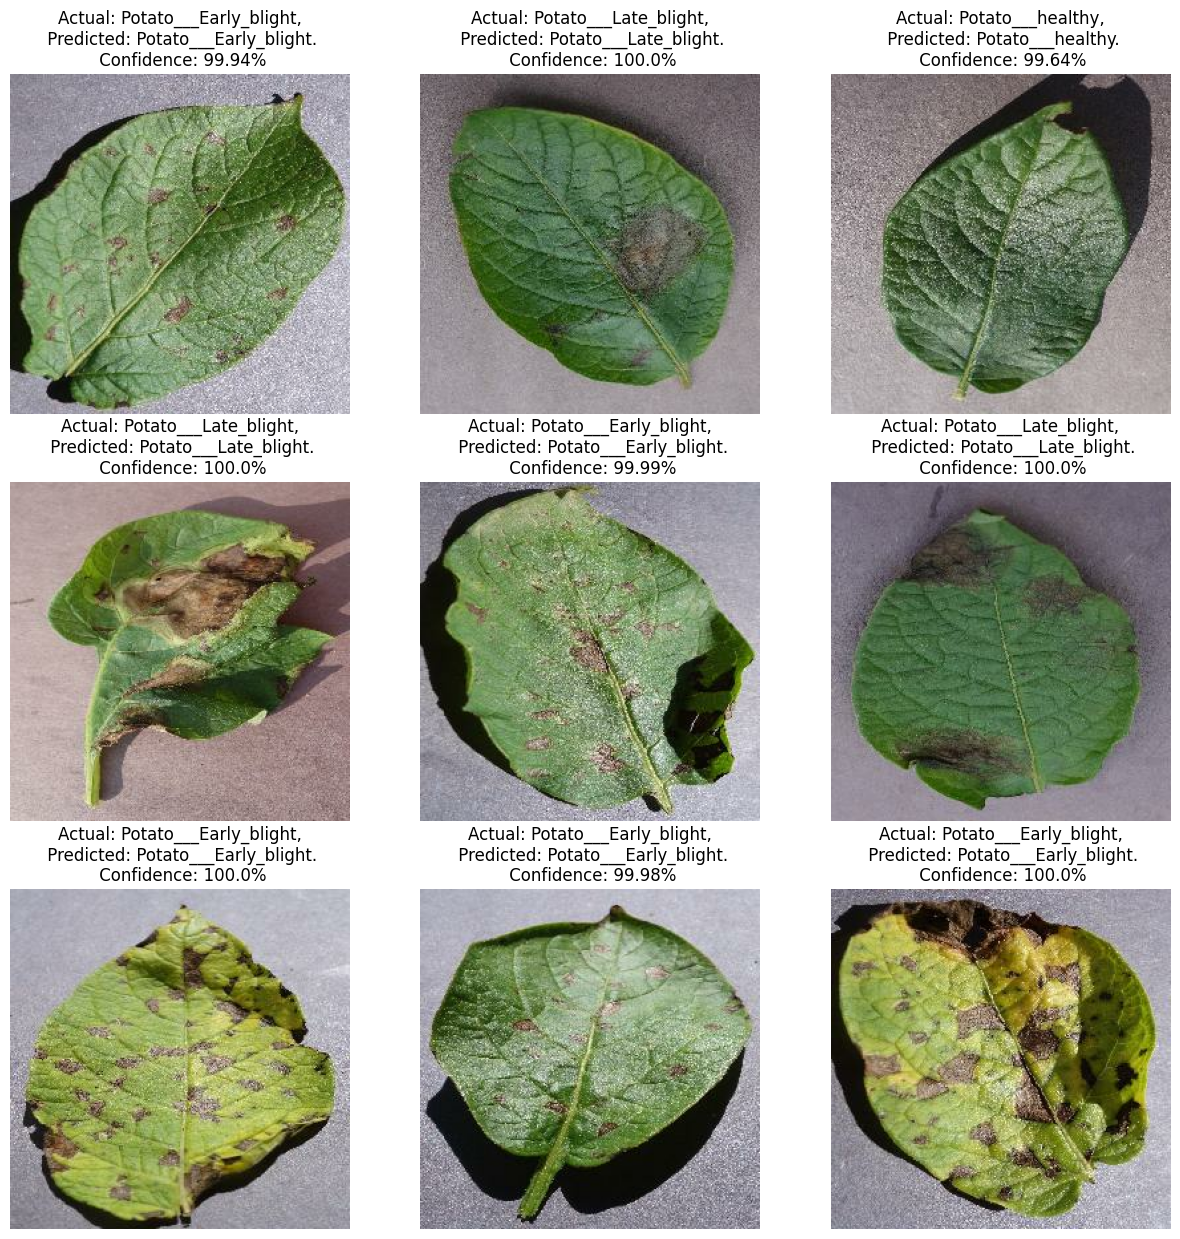

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# SVM

In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
Categories=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='PlantVillage/' 
#path which contains all the categories of images
for i in Categories:
      
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : Potato___Early_blight
loaded category:Potato___Early_blight successfully
loading... category : Potato___Late_blight
loaded category:Potato___Late_blight successfully
loading... category : Potato___healthy
loaded category:Potato___healthy successfully


In [3]:
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

(2152, 67501)

In [4]:
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=20)

In [6]:
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}
  
# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [ ]:
model.fit(x_train,y_train)

In [ ]:
y_pred = model.predict(x_test)
  
# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)
  
# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

# SVM Without GridSearch Cv

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm

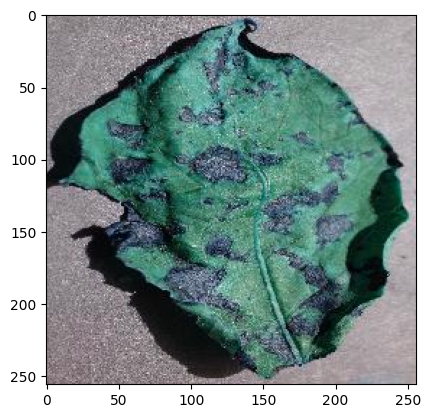

In [9]:
DATADIR = 'PlantVillage/'
CATEGORIES =['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
IMG_SIZE=100
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [10]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()      
lenofimage = len(training_data)

In [11]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
X = X/255.0

y=np.array(y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [13]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [14]:
y2 = svc.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy on potato leaf diseases data is",accuracy_score(y_test,y2))

Accuracy on potato leaf diseases data is 0.9200743494423792
